In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
from pyradiosky import SkyModel

In [2]:
sys.path.append("..")

In [3]:
from core.utils import FREQS_DICT

In [4]:
FREQS = FREQS_DICT['H4C']

In [5]:
from pyuvdata.uvdata import FastUVH5Meta

In [6]:
from pathlib import Path

In [11]:
eors = sorted(Path("../sky_models/eor/").glob("*.skyh5"))

In [12]:
len(eors)

1536

In [14]:
(eors[0].parent.parent / 'eor_mean0').mkdir()

In [20]:
mdl.freq_array

<Quantity [46920776.3671875] Hz>

In [55]:
means = []
for fl in eors:
    mdl = SkyModel.from_skyh5(str(fl))
    mdl.stokes -= 10**(res[0][0]*np.log10(mdl.freq_array[0].value) + res[0][1])*mdl.stokes.unit #(4e-24 * mdl.freq_array[0].value**3)*mdl.stokes.unit
    means.append(np.mean(mdl.stokes[0]))
    
    mdl.write_skyh5(fl.parent.parent/'eor_mean0'/fl.name, clobber=True)

File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.
File exists; clobbering.


In [32]:
from scipy.optimize import curve_fit

In [49]:
def line(x, a, b):
    return a*x + b

In [35]:
means = np.array([m.value + 4e-24*f**3 for m,f in zip(means, FREQS[100:])])

In [38]:
FREQS

array([4.69207764e+07, 4.70428467e+07, 4.71649170e+07, ...,
       2.34054565e+08, 2.34176636e+08, 2.34298706e+08])

In [50]:
res = curve_fit(line, np.log10(FREQS[100:]), np.log10(means), p0=(3, -23)) 

In [51]:
res

(array([  3.0603514 , -23.87804823]),
 array([[ 1.67627299e-05, -1.36402904e-04],
        [-1.36402904e-04,  1.11040390e-03]]))

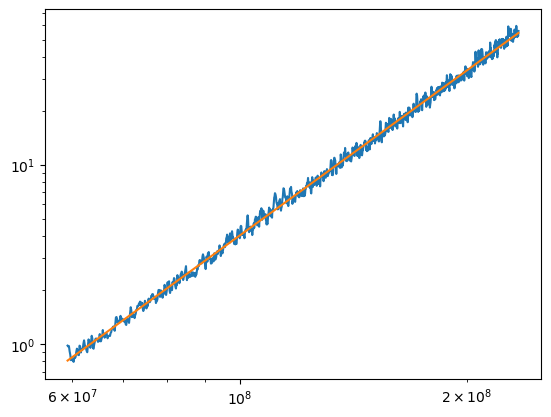

In [52]:
plt.loglog(FREQS[100:], means)
plt.loglog(FREQS[100:], 10**(res[0][0]*np.log10(FREQS[100:]) + res[0][1]))


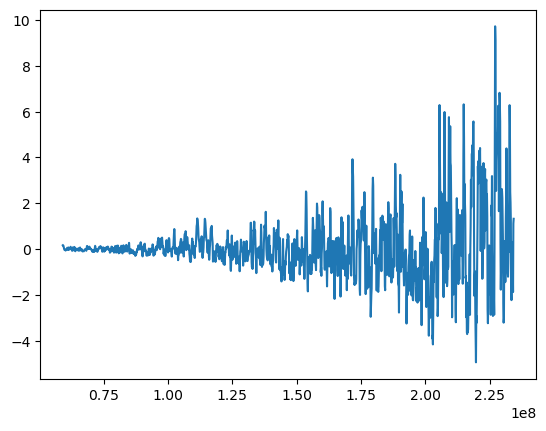

In [53]:
plt.plot(FREQS[100:], means - 10**(res[0][0]*np.log10(FREQS[100:]) + res[0][1]))

In [60]:
direc = Path("/jet/home/sgm/data/validation-sim/outputs/eor_mean0/nt17280-012chunks")

files = []
for fch in range(175,325):
    files.append(direc / f"eor_mean0_fch{fch:04d}_nt17280_chunk000.uvh5")

In [61]:
for fl in files:
    assert fl.exists()

In [62]:
f0 = files[0]

In [63]:
meta = FastUVH5Meta(f0)

In [64]:
blidx = [
    meta.antpairs.index((1,0)),
    meta.antpairs.index((2,0)),
    meta.antpairs.index((4,0)),
    meta.antpairs.index((11,0)),
    meta.antpairs.index((23,0)),
    meta.antpairs.index((52,0)),
]

In [65]:
data = np.zeros((len(files), meta.Ntimes, len(blidx), 4), dtype=complex)
freqs = np.zeros(len(files))
for i, fl in enumerate(files):
    with h5py.File(fl, 'r') as fll:
        freqs[i] = fll['Header']['freq_array'][0]
        _d = fll['Data']['visdata'][()]
        _d.shape = (meta.Ntimes, meta.Nbls, 4)
        data[i] = _d[:, blidx]

In [66]:
def make_plot(data, cmp='real', pol='xx'):
    fig, ax = plt.subplots(3, 4, sharex=True, constrained_layout=True, figsize=(12, 8), sharey=True)

    def make_half(cmp, ax):
        if pol !='pI':
            d = getattr(data, cmp)[:, :, :, meta.pols.index(pol)].T
        else:
            d = (data[:, :, :, meta.pols.index("xx")] + data[:, :, :, meta.pols.index('yy')])/2
            d = getattr(d, cmp).T

        mn = d.min()
        mx = d.max()

        ext = (freqs[0]/1e6, freqs[-1]/1e6, 2, 0)
        kw = {'extent': ext, 'aspect': 'auto', 'clim': (mn, mx)}

        img = ax[0, 0].imshow(d[0], **kw)
        ax[0, 0].set_title(f"1-unit EW, {cmp}")
        ax[0, 1].imshow(d[3], **kw)
        ax[0, 1].set_title(f"1-unit NS, {cmp}")

        ax[1, 0].imshow(d[1], **kw)
        ax[1, 0].set_title(f"2-unit EW, {cmp}")
        ax[1, 1].imshow(d[4], **kw)
        ax[1, 1].set_title(f"2-unit NS, {cmp}")

        ax[2, 0].imshow(d[2], **kw)
        ax[2, 0].set_title(f"4-unit EW, {cmp}")
        ax[2, 1].imshow(d[5], **kw)
        ax[2, 1].set_title(f"4-unit NS, {cmp}")
        return img
    
    img1 = make_half("real", ax[:, :2])
    img2 = make_half("imag", ax[:, 2:])
    
    fig.suptitle(f"pol={pol}")

    fig.colorbar(img1, ax=ax[:, :2])
    fig.colorbar(img2, ax=ax[:, 2:])

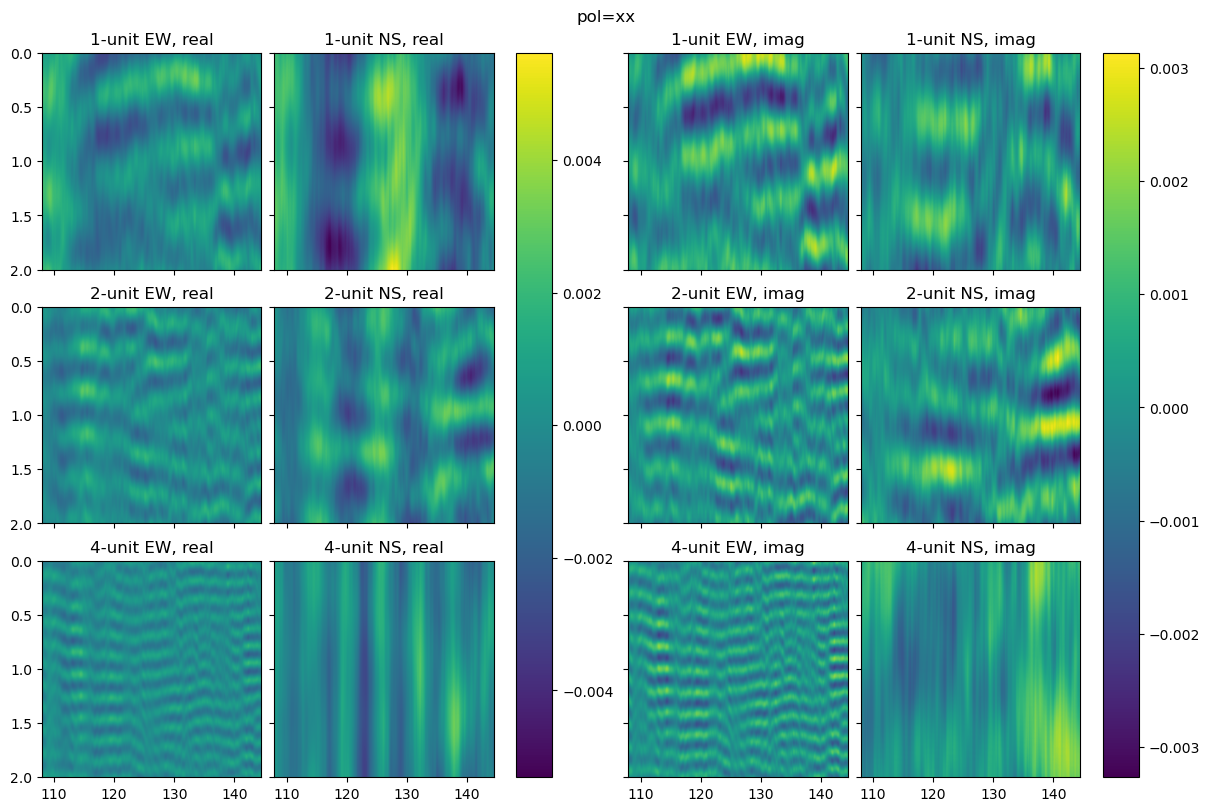

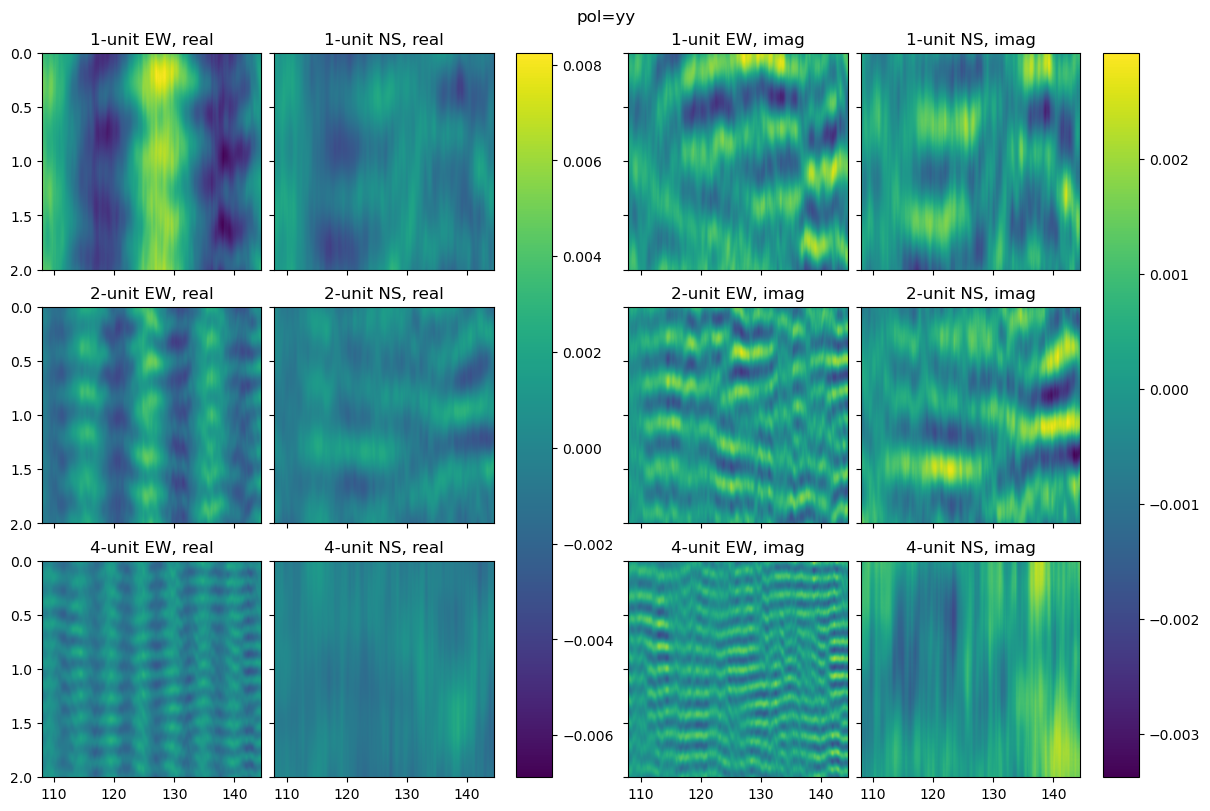

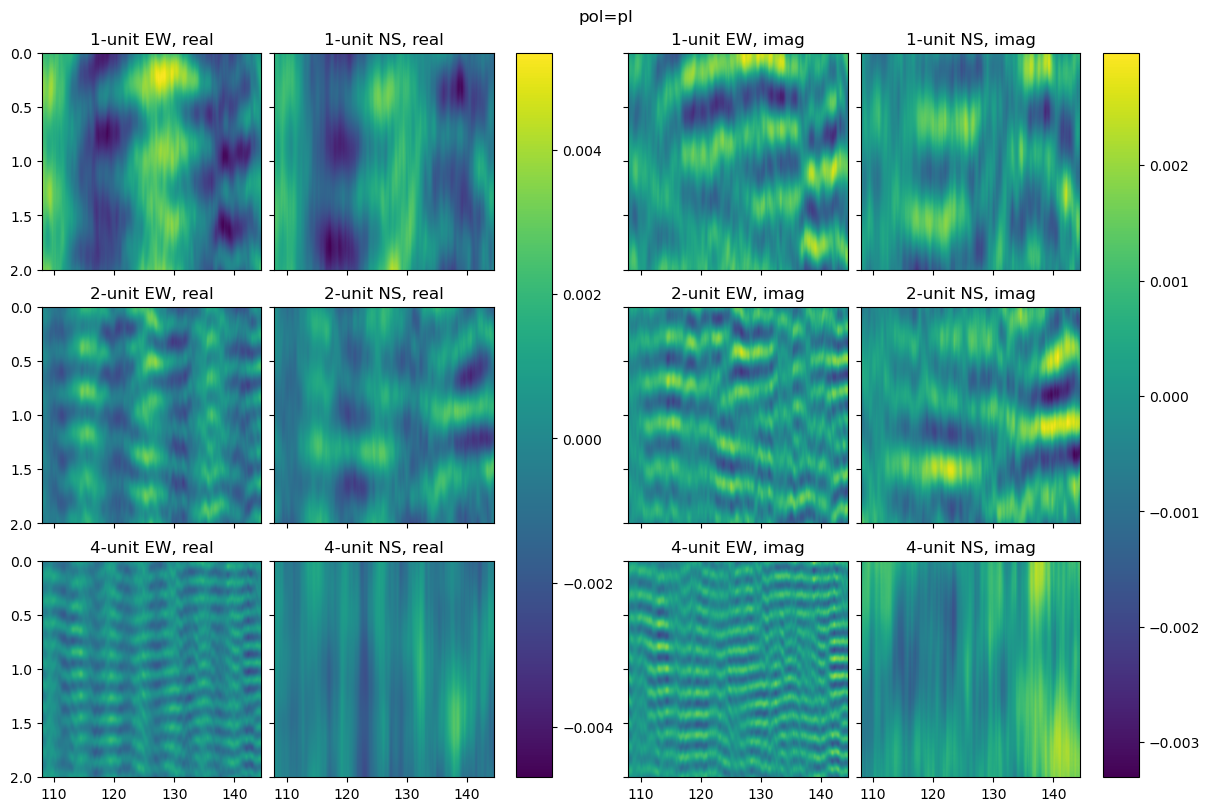

In [102]:
make_plot(data, pol='xx');
make_plot(data, pol='yy');
make_plot(data, pol='pI');


In [5]:
old_files = sorted(Path("/jet/home/sgm/data/validation-sim/outputs/eor/nt17280").glob("*_chunk0.uvh5"))[175:325]

In [6]:
old_files[0]

PosixPath('/jet/home/sgm/data/validation-sim/outputs/eor/nt17280/eor_fch0175_nt17280_chunk0.uvh5')

In [7]:
old_meta = FastUVH5Meta(old_files[0])

In [8]:
np.linalg.norm(old_meta.uvw_array, axis=1).shape

(4072320,)

In [9]:
bllen = np.linalg.norm(old_meta.uvw_array[:old_meta.Nbls], axis=1)
idx = np.where(np.logical_and(bllen< 80.0, bllen>0))[0]

In [10]:
idx

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  14,  15,
        16,  17,  18,  19,  20,  22,  23,  24,  25,  29,  30,  31,  32,
        35,  36,  37,  38,  43,  44,  45, 126, 127, 128, 130, 151, 152,
       153, 154, 155, 156, 171, 172, 173, 174, 176, 178, 191, 192, 194,
       196, 198, 270, 283, 285, 325, 327, 360, 361, 362, 364, 366, 376,
       378, 380, 382, 391, 393, 395, 397, 426, 427, 428, 434, 442, 443,
       444, 445, 456, 461, 462, 463, 469, 470, 471, 480, 481, 482, 483,
       484, 493, 494, 496, 509, 511, 513, 515, 524, 525, 526, 535, 544,
       545, 555, 568, 582, 583, 584, 585, 586, 594, 595, 596, 597, 606,
       607, 608, 616, 617, 618, 619, 620, 628, 629, 637, 638, 639, 640,
       646, 647, 648, 649, 650, 658, 659, 667, 668, 669, 694, 697, 698,
       699, 700, 701, 702, 703, 704, 705, 706])

In [7]:
bl_idx = [
    old_meta.antpairs.index((1,0)), 
    old_meta.antpairs.index((2,0)), 
    old_meta.antpairs.index((4,0)), 
    old_meta.antpairs.index((11,0)), 
    old_meta.antpairs.index((23,0)), 
    old_meta.antpairs.index((52,0))
]

In [11]:
max_idx = 720 * old_meta.Nbls

In [12]:
old_shape = (len(old_files),) + (720, len(idx), 4)

In [13]:
old_data = np.zeros(old_shape, dtype=complex)
for i, fl in enumerate(old_files):
    with h5py.File(fl, 'r') as fll:
        _d = fll['Data']['visdata'][:max_idx]
        _d.shape = (720, old_meta.Nbls, 4)
        old_data[i] = _d[:, idx]

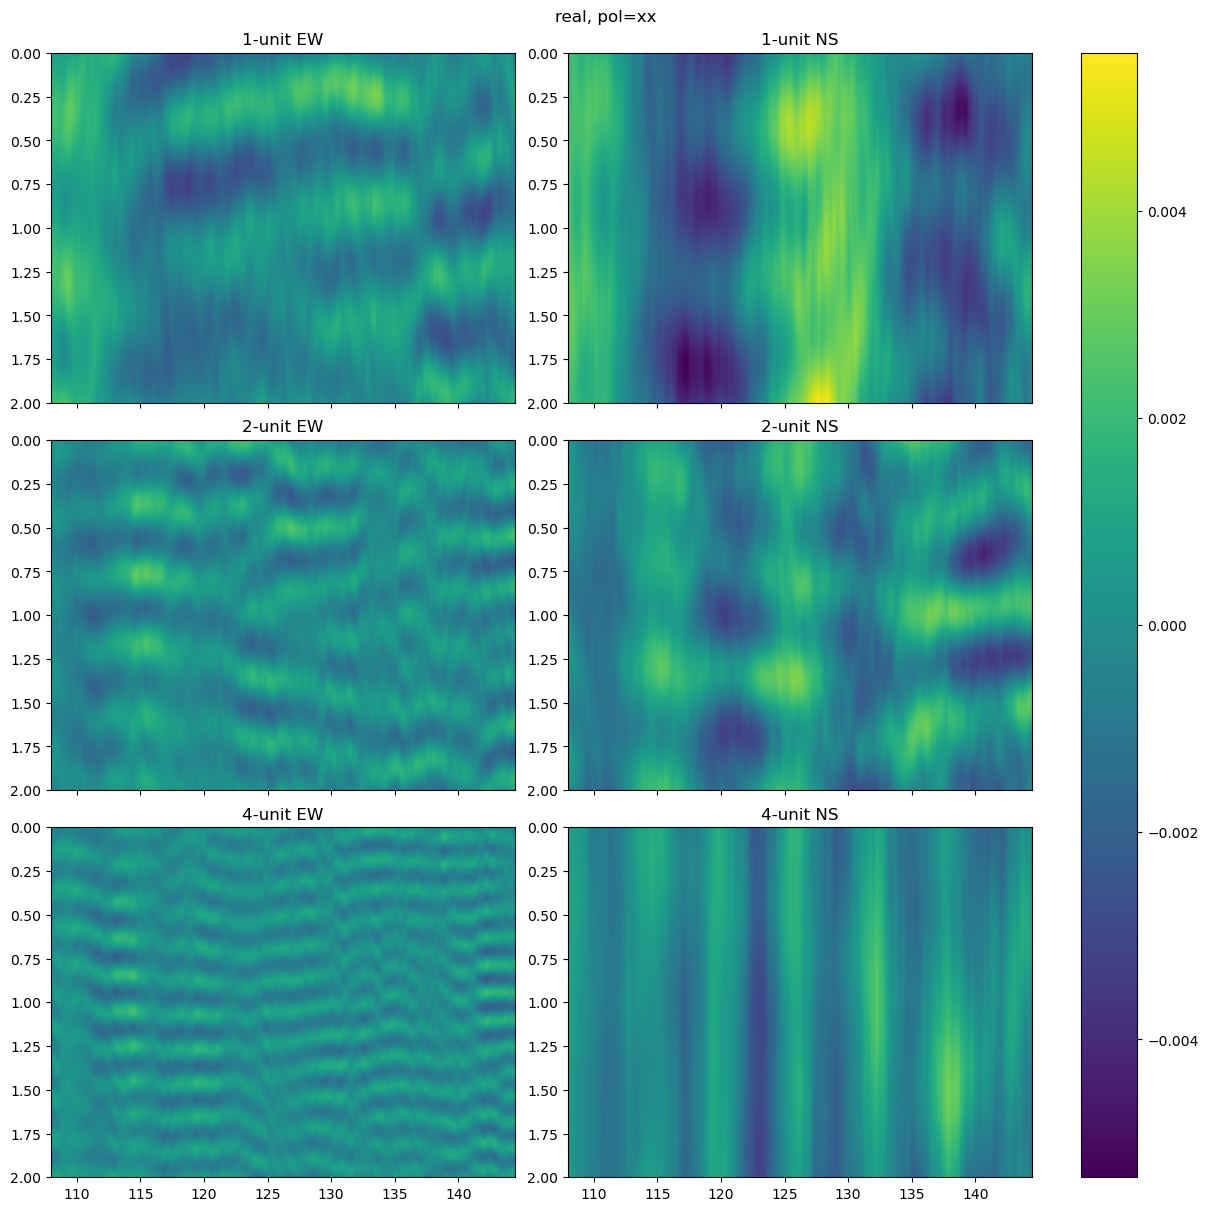

In [53]:
make_plot(old_data, 'real', 'xx')

In [54]:
diff = data - old_data

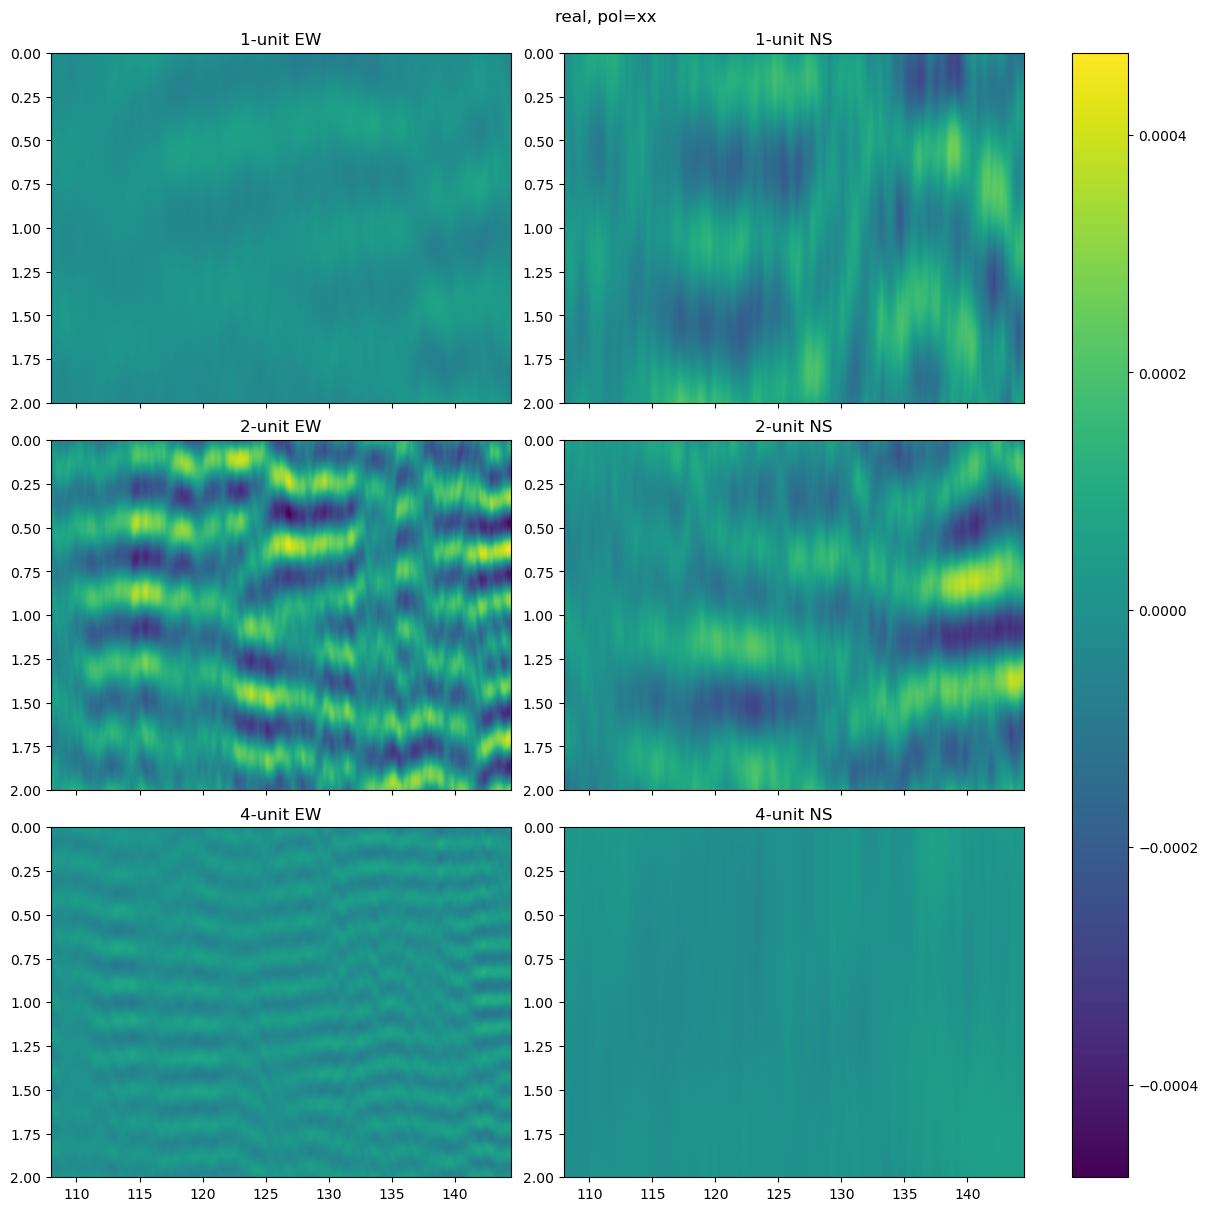

In [56]:
make_plot(diff, 'real', 'xx')

## Power Spectra

In [14]:
import hera_pspec as hp
from scipy.signal import blackmanharris

In [15]:
cc = hp.conversions.Cosmo_Conversions()

In [16]:
data.shape

NameError: name 'data' is not defined

In [59]:
def get_power(data, pol='xx'):
    if pol=='pI':
        dd = (data.T[0] + data.T[-1])/2
    else:
        dd = data.T[meta.pols.index(pol)]
        
    power = np.abs(np.fft.fft(dd * blackmanharris(data.shape[0]), axis=-1))**2
    power = power[bllen[idx]>30]
    print(power.shape)
    fac = cc.tau_to_kpara(z=6.7)
    return np.fft.fftshift(np.mean(power, axis=(0,1))), np.fft.fftshift(np.mean(power, axis=1), axes=(1,)), np.fft.fftshift(np.fft.fftfreq(data.shape[0], d=FREQS[1]-FREQS[0]) * fac)
    

In [86]:
new_power_xx, kfft = get_power(data, 'xx')
new_power_yy, kfft = get_power(data, 'yy')
new_power_pi, kfft = get_power(data, 'pI')


In [60]:
old_power, old_power_bls, kfft = get_power(old_data, 'pI')

(133, 720, 150)


In [41]:
old_power_bls.shape

(151, 150)

In [52]:
rms = np.sum(np.log(old_power_bls / old_power)**2, axis=1)

In [46]:
rms.shape

(151,)

In [48]:
these_uvws = old_meta.uvw_array[:old_meta.Nbls][idx]

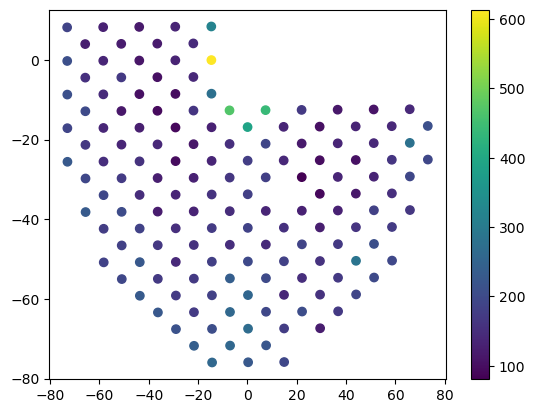

In [53]:
plt.scatter(these_uvws[:, 0], these_uvws[:, 1], c=rms)
plt.colorbar()

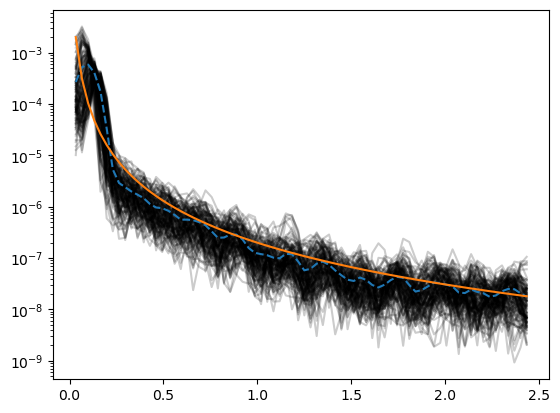

In [61]:
mask = kfft > 0

#plt.plot(kfft[mask], new_power_xx[mask])
#plt.plot(kfft[mask], new_power_yy[mask])
#plt.plot(kfft[mask], new_power_pi[mask])

for bl in old_power_bls:
    plt.plot(kfft[mask], bl[mask], color='k', alpha=0.2)

plt.plot(kfft[mask], old_power[mask], ls='--')

plt.plot(kfft[mask], 2e-7 * kfft[mask]**-2.7)
plt.yscale('log')

## Simulate

In [62]:
from hera_sim.visibilities import ModelData, load_simulator_from_yaml
from matvis import conversions as convs

In [63]:
mdl = ModelData.from_config("/jet/home/sgm/data/validation-sim/config_files/obsparams/eor/nt17280_12chunks/fch0500_chunk000.yaml", normalize_beams=True)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.
All polarized beams have x_orientation set to None. This will make it hard to interpret the polarizations of the simulated visibilities.


In [64]:
matvis = load_simulator_from_yaml("/jet/home/sgm/data/validation-sim/viscpu.yaml")

In [65]:
matvis.compress_data_model(mdl)

In [66]:
data_model = mdl

In [67]:
data_model.sky_model.healpix_to_point()

In [68]:
ra, dec = matvis.correct_point_source_pos(mdl)

In [69]:
crd_eq = convs.point_source_crd_eq(ra, dec)

In [70]:
eq2tops_full = matvis.get_eq2tops(data_model.uvdata, data_model.lsts)

In [71]:
active_antpos, ant_list = data_model.uvdata.get_ENU_antpos(pick_data_ants=True)

In [72]:
feed = matvis.get_feed(data_model.uvdata)

In [73]:
feed

'x'

In [147]:
ant_list

array([ 0,  1,  2,  4, 11, 23, 52], dtype=int32)

In [74]:
beam_list = [
    convs.prepare_beam(
        beam,
        polarized=True,
        use_feed=feed,
    )
    for beam in data_model.beams
]
beam_ids = np.array(
    [
        data_model.beam_ids[nm]
        for i, nm in zip(
            data_model.uvdata.antenna_numbers, data_model.uvdata.antenna_names
        )
        if i in ant_list
    ]
)

In [75]:
beam_list[0].feed_array

array(['x', 'y'], dtype='<U1')

In [76]:
req_pols = matvis._get_req_pols(
    data_model.uvdata, data_model.beams[0], polarized=True
)

In [77]:
req_pols

[(0, 0), (0, 1), (1, 0), (1, 1)]

In [78]:
from matvis.cpu import simulate

In [80]:
from matvis.cpu import _validate_inputs, _wrangle_beams, _evaluate_beam_cpu, _get_antenna_vis
from astropy.constants import c

In [82]:
precision = matvis._precision
I_sky = data_model.sky_model.stokes[0, 0].to("Jy").value
antpos = active_antpos
freq = data_model.freqs[0]
polarized=True
beam_idx=beam_ids
beam_spline_opts=data_model.beams.spline_interp_opts
eqtops = eq2tops_full

In [84]:
skymeans = np.zeros(300)
skystds = np.zeros(300)

for i, j in enumerate(range(500, 800)):
    fl = Path(f"/jet/home/sgm/data/validation-sim/sky_models/eor/fch0{j}.skyh5")
    with h5py.File(fl,'r') as _fl:
        d = _fl['Data']['stokes'][0,0,:]
    skymeans[i] = np.mean(d)
    skystds[i] = np.std(d)

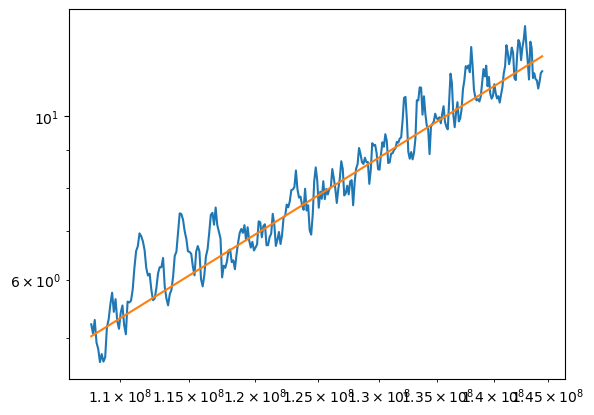

In [91]:
plt.plot(FREQS[500:800], skymeans)
plt.plot(FREQS[500:800], 4e-24 * FREQS[500:800]**3)

plt.xscale('log')
plt.yscale('log')

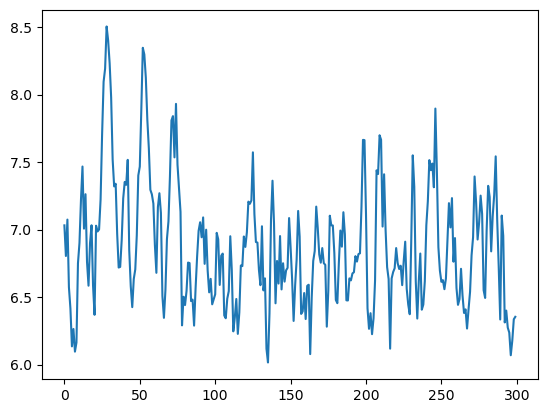

In [153]:
plt.plot(skymeans / skystds)

In [ ]:
nax, nfeed, nant, ntimes = _validate_inputs(
    precision, polarized, antpos, eq2tops_full, crd_eq, I_sky
)

if precision == 1:
    real_dtype = np.float32
    complex_dtype = np.complex64
else:
    real_dtype = np.float64
    complex_dtype = np.complex128


# Intensity distribution (sqrt) and antenna positions. Does not support
# negative sky. Factor of 0.5 accounts for splitting Stokes I between
# polarization channels
Isqrt = np.ones_like(I_sky) #np.sqrt(0.5 * I_sky).astype(real_dtype)
antpos = antpos.astype(real_dtype)


# Zero arrays: beam pattern, visibilities, delays, complex voltages
vis = np.full((2, 300, ntimes, nfeed * nant, nfeed * nant), 0.0, dtype=complex_dtype)

crd_eq = crd_eq.astype(real_dtype)
eq2tops = eq2tops_full[-1:]

In [157]:
# Loop over time samples
for j, freq in enumerate(h4c_freqs[500:800]):
    beam_list, nbeam, beam_idx = _wrangle_beams(
        beam_idx, beam_list, polarized, nant, freq
    )
    ang_freq = real_dtype(2.0 * np.pi * freq)
    
    sky_model = SkyModel.from_skyh5(f"/jet/home/sgm/data/validation-sim/sky_models/eor/fch0{500+j}.skyh5")
    sky_model.healpix_to_point()
    
    I_sky = sky_model.stokes[0, 0].to("Jy").value
    Isqrt = np.array([np.sqrt(0.5 * I_sky).astype(real_dtype), np.ones_like(I_sky)*np.mean(np.sqrt(0.5 * I_sky).astype(real_dtype))]).T
    
    for t, eq2top in enumerate(eq2tops.astype(real_dtype)):
        # Dot product converts ECI cosines (i.e. from RA and Dec) into ENU
        # (topocentric) cosines, with (tx, ty, tz) = (e, n, u) components
        # relative to the center of the array
        tx, ty, tz = crd_top = np.dot(eq2top, crd_eq)
        above_horizon = tz > 0
        tx = tx[above_horizon]
        ty = ty[above_horizon]
        nsrcs_up = len(tx)
        isqrt = Isqrt[above_horizon]

        A_s = np.full((nax, nfeed, nbeam, nsrcs_up), 0.0, dtype=complex_dtype)

        _evaluate_beam_cpu(
            A_s,
            beam_list,
            tx,
            ty,
            polarized,
            freq,
            check=t == 0,
            spline_opts=beam_spline_opts,
        )
        A_s = A_s.transpose((1, 2, 0, 3))  # Now (Nfeed, Nbeam, Nax, Nsrc)

        # Calculate delays, where tau = (b * s) / c
        tau = np.dot(antpos / c.value, crd_top[:, above_horizon])
    
        for sky in range(2):
            v = _get_antenna_vis(
                A_s, ang_freq, tau, isqrt[:, sky], beam_idx, nfeed, nant, nax, nsrcs_up
            )

            # Compute visibilities using product of complex voltages (upper triangle).
            vis[sky, j, t] = v.conj().dot(v.T)

In [158]:
v.shape = (nfeed, nant, nax, nsrcs_up)

ValueError: cannot reshape array of size 2752484 into shape (2,2,7,2,98303)

In [159]:
vis.shape = (2, 300, ntimes, nfeed, nant, nfeed, nant)

In [106]:
import healpy as hp

In [129]:
vis.shape

(300, 1, 14, 14)

In [142]:
data.shape

(300, 1440, 6, 4)

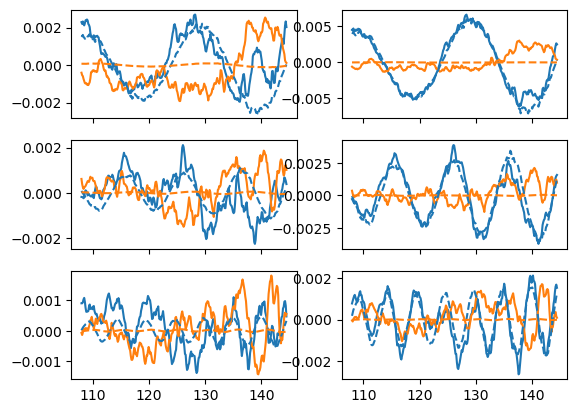

In [162]:
fig, ax = plt.subplots(3,2, sharex=True)

for ant2 in (1,2,3):
    for pol in range(2):
        for sky in range(2):
            ax[ant2-1, pol].plot(h4c_freqs[500:800]/1e6, vis[sky, :, 0, pol, ant2, pol, 0].real, ls='--' if sky else '-', label=f'real, sky={sky}', color='C0')
            ax[ant2-1, pol].plot(h4c_freqs[500:800]/1e6, vis[sky, :, 0, pol, ant2, pol, 0].imag, ls='--' if sky else '-', label=f'imag, sky={sky}', color='C1')

#plt.plot(freqs/1e6, data[:, 0, 0, 0]*1000)

In [107]:
def getbeam(feed, ax):
    fullA = np.full(hp.nside2npix(128), np.nan, dtype=complex)
    fullA[above_horizon] = A_s[feed, 0, ax]
    return fullA

def getpowerbeam(feed):
    fullA = np.full(hp.nside2npix(128), np.nan)
    fullA[above_horizon] = np.abs(A_s[feed, 0, 0])**2 + np.abs(A_s[feed, 0, 1])**2
    return fullA
    

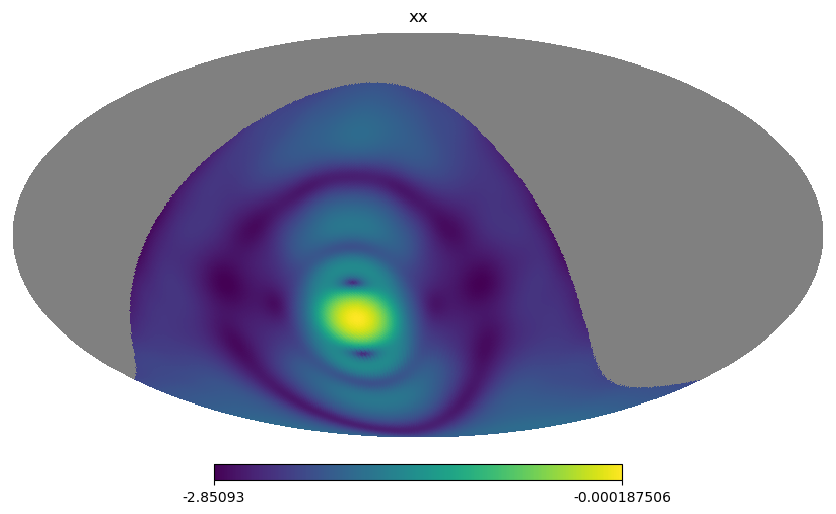

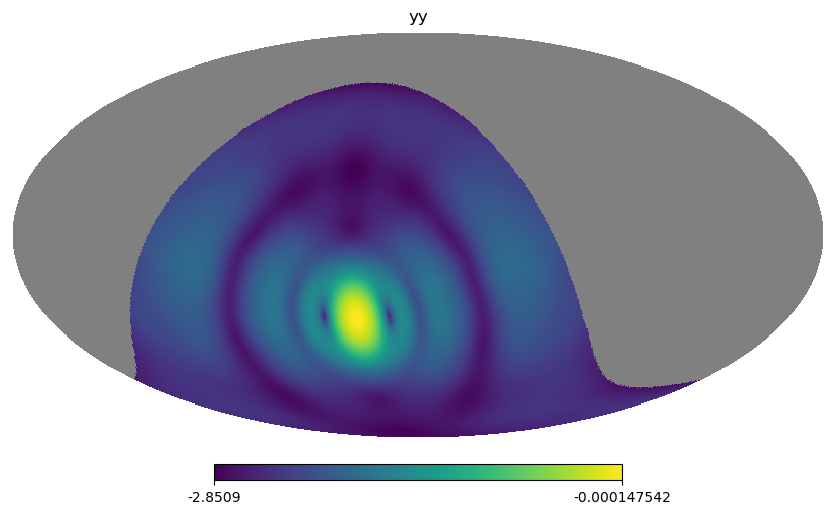

In [108]:
hp.mollview(np.log10(getpowerbeam(0)), title='xx')
hp.mollview(np.log10(getpowerbeam(1)), title='yy')

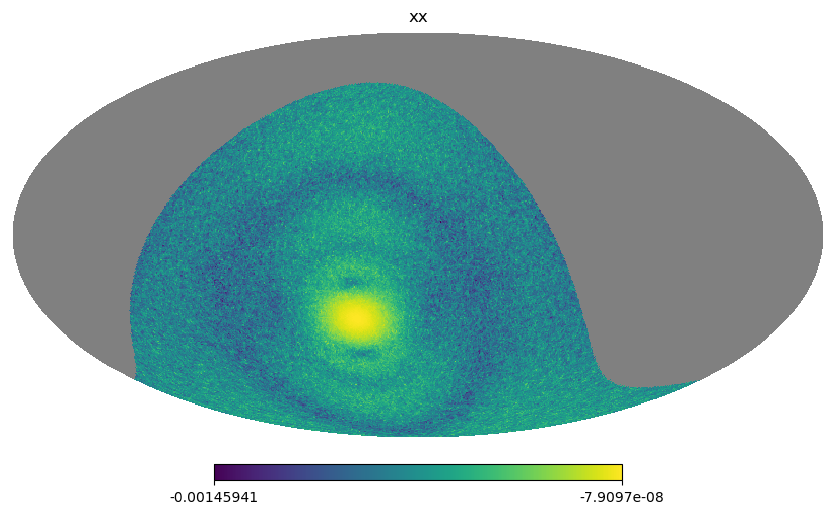

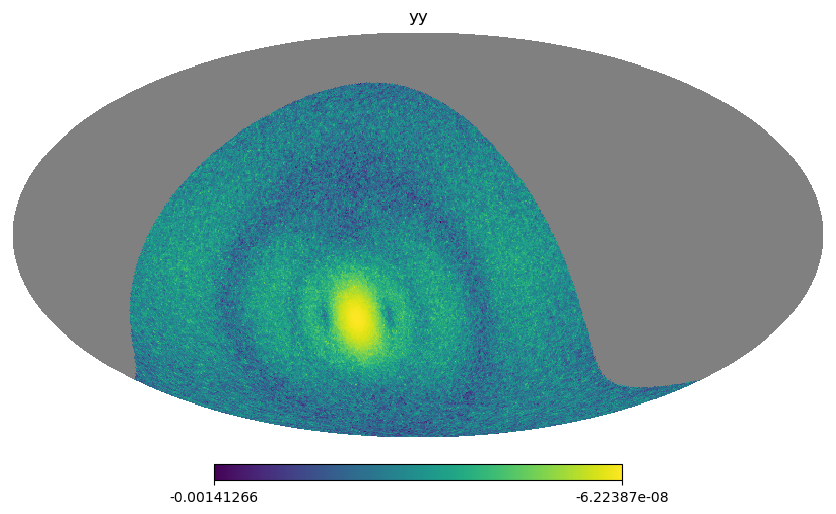

In [109]:
hp.mollview(np.log10(getpowerbeam(0))*I_sky, title='xx')
hp.mollview(np.log10(getpowerbeam(1))*I_sky, title='yy')

In [110]:
def get_powerv(feed, ant1, ant2):
    z = v[feed, ant1, 0]*v[feed, ant2, 0].conj() + v[feed, ant1, 1]*v[feed, ant2, 1].conj()
    fullA = np.full(hp.nside2npix(128), np.nan, dtype=complex)
    fullA[above_horizon]=z
    return fullA

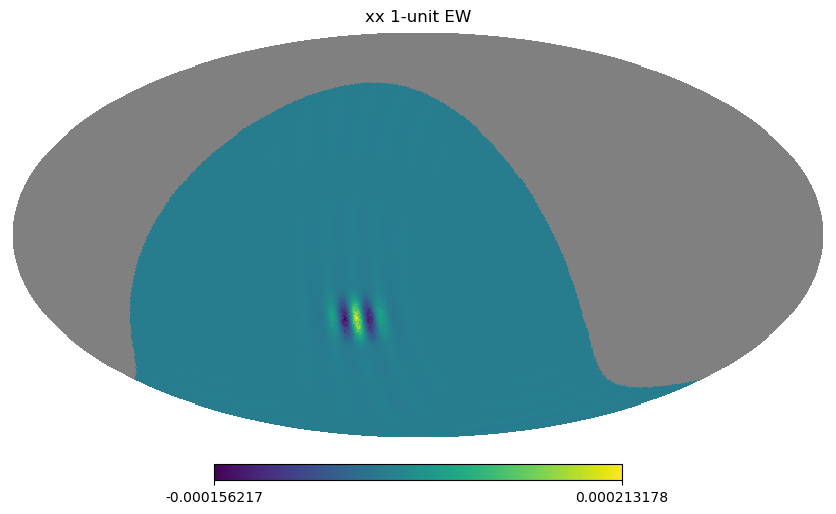

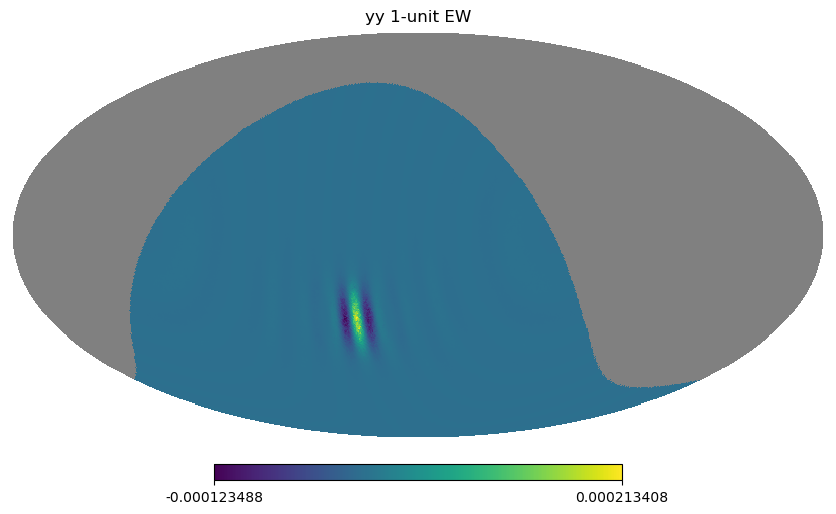

In [111]:
hp.mollview(get_powerv(0, 0, 1).real, title='xx 1-unit EW')
hp.mollview(get_powerv(1, 0, 1).real, title='yy 1-unit EW')

In [114]:
np.mean(data_model.sky_model.stokes[0,0])

<Quantity 0.00033394 Jy>

In [115]:
np.std(data_model.sky_model.stokes[0,0])

<Quantity 4.74945445e-05 Jy>

In [116]:
from pyradiosky import SkyModel

In [117]:
highnu_sky = SkyModel.from_skyh5("/jet/home/sgm/data/validation-sim/sky_models/eor/fch1530.skyh5")

In [118]:
np.mean(highnu_sky.stokes[0,0])

<Quantity 52.33584778 Jy / sr>

In [119]:
np.std(highnu_sky.stokes[0,0])


<Quantity 8.01327351 Jy / sr>